Autores:

**Gustavo José Aguado Perianes, Alejandro Hernández García y Emma Reyner Fuentes**

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


Importamos lo necesario

In [ ]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# 0. Funciones


In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


# 1. Carga de datos

## 1.1. Descargamos los datos de entrenamiento y test

In [ ]:
# Descargamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 3s 0us/step


## 1.2. Seleccionamos las clases a utilizar

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Las imágenes son tamaño 60x60
IMG_SIZE = 60

## 1.3. Cargamos los datos

In [ ]:
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

# Normalizamos
X = X/255.0
X_t = X_t/255.0

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


## 1.4. Separamos conjunto de validación

In [ ]:
# Inicializamos con semilla para mantener cierta estabilidad entre ejecuciones pese a barajar las muestras
np.random.seed(123)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.5. Mostramos una imagen de ejemplo

El tamaño de la imagen es:  (60, 60, 3)
La clase de la imagen es:  7


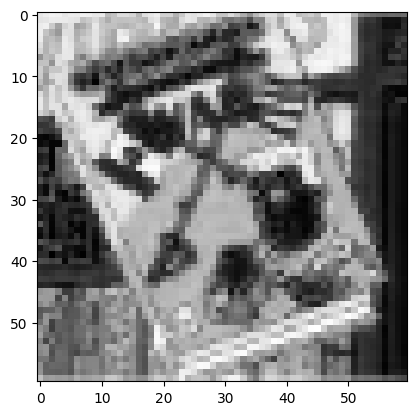

In [ ]:
img = X_t[15]
print("El tamaño de la imagen es: ", img.shape)
print("La clase de la imagen es: ", y[15])
plt.imshow(img[:,:,0],cmap='gray') 

# 2. Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## 2.1. Análisis Exploratiorio de los Datos (EDA)

El primer paso es visualizar cuántas imágenes tenemos en cada uno de los conjuntos de datos

In [ ]:
# Veamos cuantas imagenes tenemos de cada tipo de dataset
print("Hay un total de ", len(X), " imágenes en el conjunto de entrenamiento")
print("Hay un total de ", len(X_val), " imágenes en el conjunto de validación")
print("Hay un total de ", len(X_t), " imágenes en el conjunto de test")

Hay un total de  15193  imágenes en el conjunto de entrenamiento
Hay un total de  3799  imágenes en el conjunto de validación
Hay un total de  890  imágenes en el conjunto de test


Ya se ha visto antes, en 1.5, que el tamaño de las imágenes es de 60x60 y que disponemos de 3 capas por imagen, es decir, están en formato RGB. A continuación, vamos a explorar el vector y (de entrenamiento) y ver cómo es una instancia:

In [ ]:
print("El vector y (de entrenamiento) tiene la forma ", y.shape)
print("Una instancia de y tiene la siguiente forma: ", y[0])

El vector y (de entrenamiento) tiene la forma  (15193,)
Una instancia de y tiene la siguiente forma:  13


El vector y contiene un número que hace referencia a la clase a la que pertenece la imagen que se encuentra en el mismo índice en X. Como vimos al mapear en 1.2., cada número hace referencia a las siguientes clases:

0: 'abraham_grampa_simpson',

1: 'apu_nahasapeemapetilon', 

2: 'bart_simpson',

3: 'charles_montgomery_burns', 

4: 'chief_wiggum', 

5: 'comic_book_guy', 

6: 'edna_krabappel', 

7: 'homer_simpson', 

8: 'kent_brockman', 

9: 'krusty_the_clown', 

10: 'lisa_simpson', 

11: 'marge_simpson', 

12: 'milhouse_van_houten', 

13: 'moe_szyslak', 

14: 'ned_flanders', 

15: 'nelson_muntz', 

16: 'principal_skinner', 

17: 'sideshow_bob'

A continuación, visualizaremos una instancia de cada clase y, después veremos cuántas instancias tenemos en total de cada clase.

Esto es una instancia de la clase  0


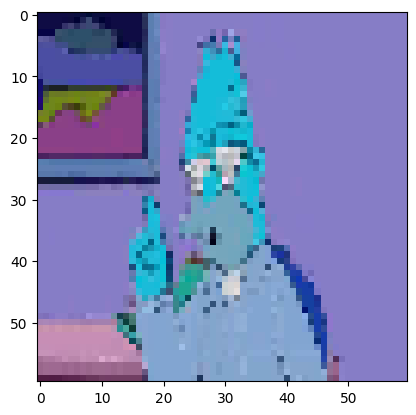

Esto es una instancia de la clase  1


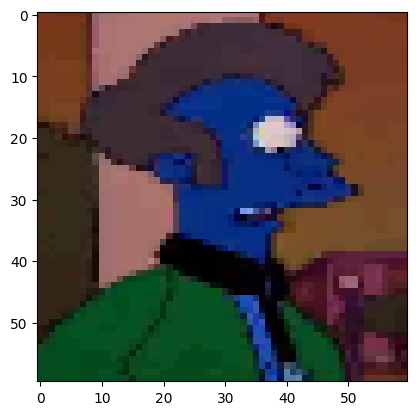

Esto es una instancia de la clase  2


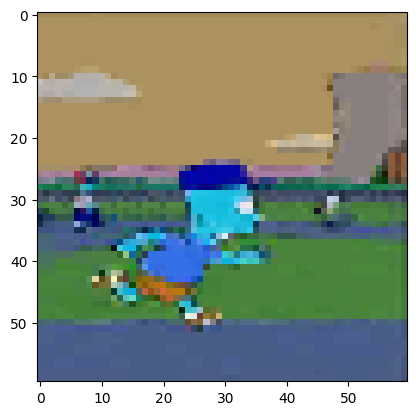

Esto es una instancia de la clase  3


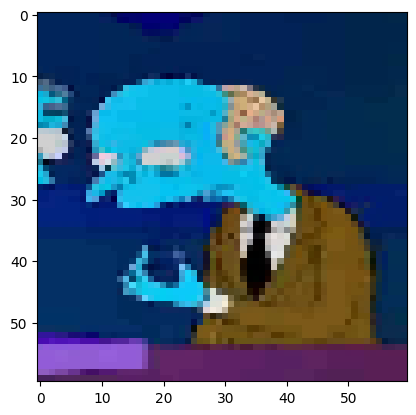

Esto es una instancia de la clase  4


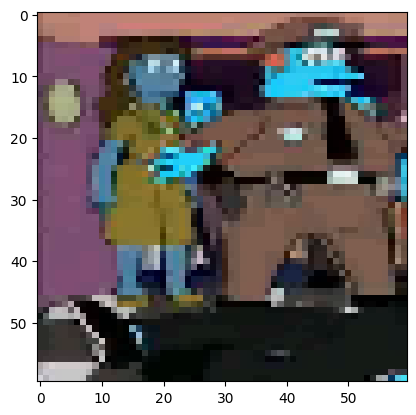

Esto es una instancia de la clase  5


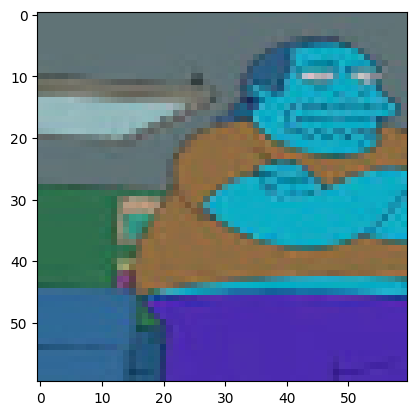

Esto es una instancia de la clase  6


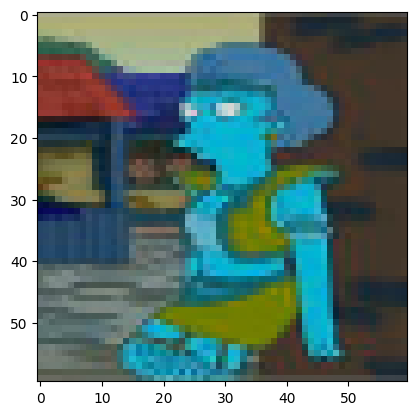

Esto es una instancia de la clase  7


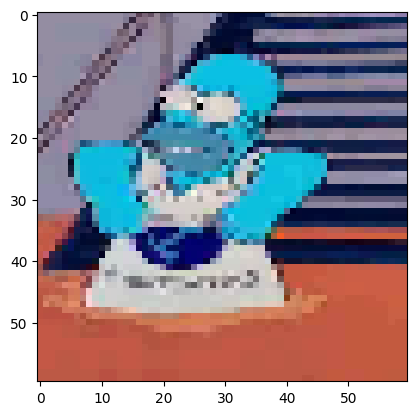

Esto es una instancia de la clase  8


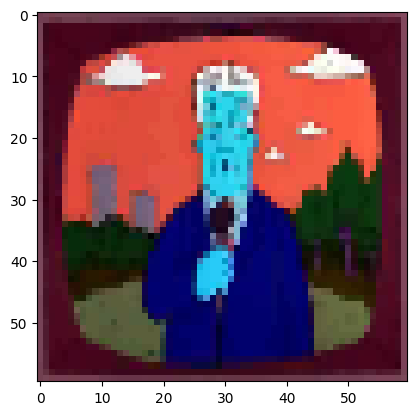

Esto es una instancia de la clase  9


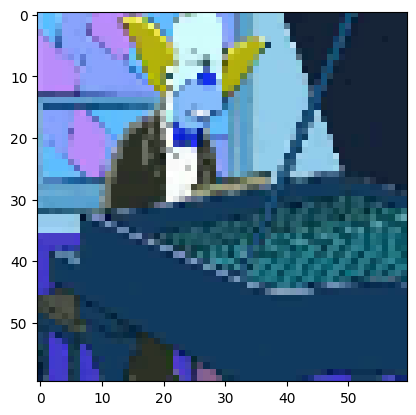

Esto es una instancia de la clase  10


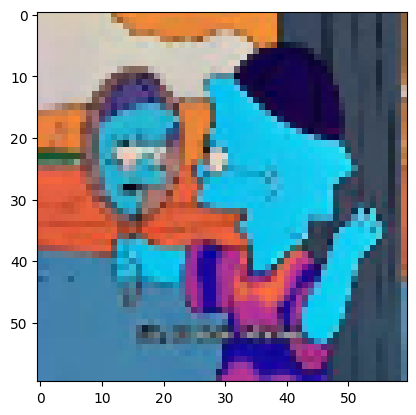

Esto es una instancia de la clase  11


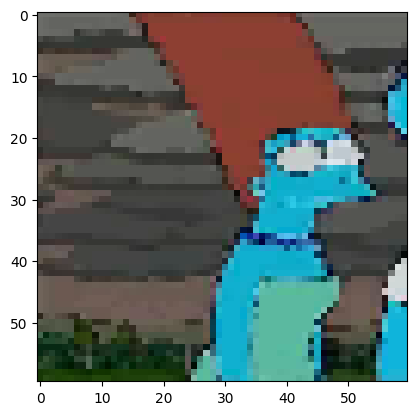

Esto es una instancia de la clase  12


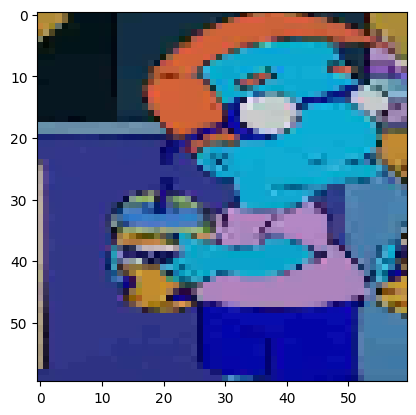

Esto es una instancia de la clase  13


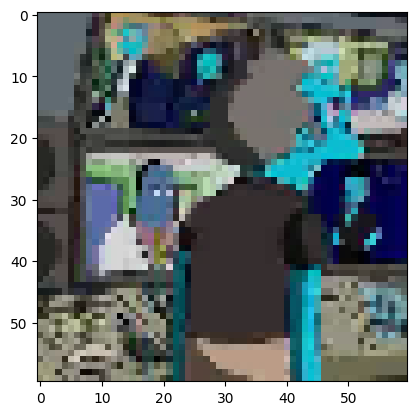

Esto es una instancia de la clase  14


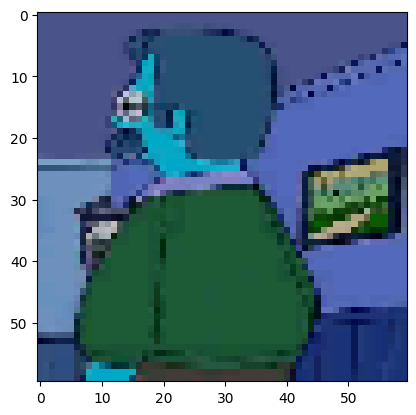

Esto es una instancia de la clase  15


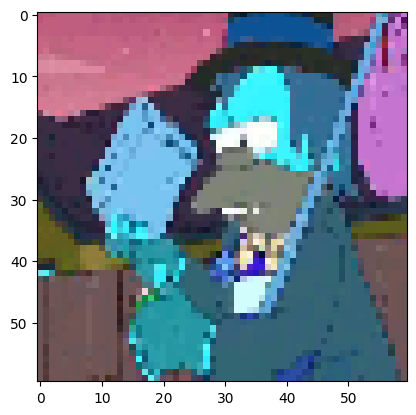

Esto es una instancia de la clase  16


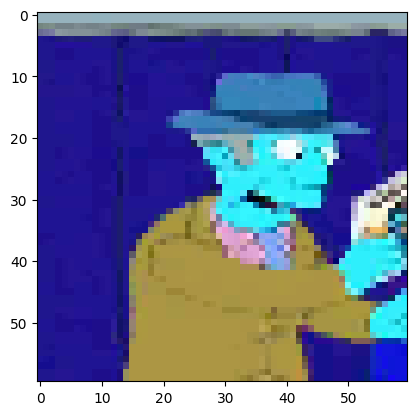

In [ ]:
# Vemos una instancia de cada clase:
for i in range(0, 17):
  for j in range(0, len(y)):
    if y[j] == i:
      print("Esto es una instancia de la clase ", i)
      plt.imshow(X[j]) 
      plt.show() 
      break

In [ ]:
# Vemos cuántas muestras tenemos por clase
(classes, counts) = np.unique(y, return_counts = True)
for cl in classes:
  print("Hay ", counts[cl], " instancias de la clase ", cl, "en el conjunto de entrenamiento")

(classes_val, counts_val) = np.unique(y_val, return_counts = True)
for cl in classes_val:
  print("Hay ", counts[cl], " instancias de la clase ", cl, "en el conjunto de validación")

(classes_t, counts_t) = np.unique(y_t, return_counts = True)
for cl in classes_t:
  print("Hay ", counts[cl], " instancias de la clase ", cl, "en el conjunto de test")

Hay  747  instancias de la clase  0 en el conjunto de entrenamiento
Hay  487  instancias de la clase  1 en el conjunto de entrenamiento
Hay  1089  instancias de la clase  2 en el conjunto de entrenamiento
Hay  957  instancias de la clase  3 en el conjunto de entrenamiento
Hay  784  instancias de la clase  4 en el conjunto de entrenamiento
Hay  388  instancias de la clase  5 en el conjunto de entrenamiento
Hay  375  instancias de la clase  6 en el conjunto de entrenamiento
Hay  1770  instancias de la clase  7 en el conjunto de entrenamiento
Hay  401  instancias de la clase  8 en el conjunto de entrenamiento
Hay  958  instancias de la clase  9 en el conjunto de entrenamiento
Hay  1070  instancias de la clase  10 en el conjunto de entrenamiento
Hay  1026  instancias de la clase  11 en el conjunto de entrenamiento
Hay  862  instancias de la clase  12 en el conjunto de entrenamiento
Hay  1159  instancias de la clase  13 en el conjunto de entrenamiento
Hay  1164  instancias de la clase  14 e

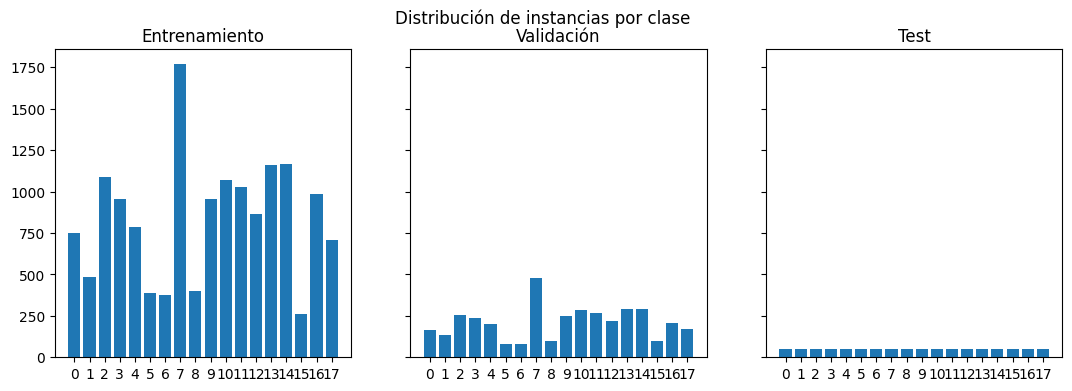

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
axs[0].bar(classes,counts, tick_label = classes)
axs[0].set_title("Entrenamiento")
axs[1].bar(classes_val,counts_val, tick_label = classes_val)
axs[1].set_title("Validación")
axs[2].bar(classes_t,counts_t, tick_label = classes_t)
axs[2].set_title("Test")
fig.suptitle('Distribución de instancias por clase')

plt.show()

Se puede observar como el dataset que cargamos de train originalmente está desbalanceado, lo que provoca que los conjuntos de train y de validación estén desbalanceados; mientras que el de test está balanceado y es uniforme. Esto provocará que el modelo clasifique mejor clases como la 7, mucho mejor representadas, de lo que clasificará clases como la 15, con una representación mucho menor. 






## 2.2. Crear el modelo



Ahora que ya sabemos cómo son nuestros datos, vamos a crear y entrenar un modelo que funcione de la mejor manera posible para ellos.

### 2.2.0. Crear y entrenar un modelo de fully connected layers

El primer paso será probar a entrenar un modelo normal, creado con capas Dense, para compararlo con el modelo de redes convolucionales

In [ ]:
# Transformamos las etiquetas a one-hot-vectors
y = to_categorical(y, num_classes=18)
y_t = to_categorical(y_t, num_classes=18)
y_val = to_categorical(y_val, num_classes=18)

In [ ]:
# Iniciamos el modelo
model0 = Sequential()

# Introducimos una capa flatten para convertir las imágenes a vector y poder 
#pasárselas a las fully connected layers
model0.add(Flatten())

# Añadimos las capas dense utilizando regularización Dropout
model0.add(Dense(512, activation='selu'))
model0.add(Dropout(0.5))
model0.add(Dense(256, activation='selu'))
model0.add(Dropout(0.3))
model0.add(BatchNormalization())
model0.add(Dense(256, activation='selu'))
model0.add(Dropout(0.3))
model0.add(BatchNormalization())
model0.add(Dense(128, activation='selu'))
model0.add(BatchNormalization())
model0.add(Dense(18, activation='softmax'))

# Compilamos el modelo
model0.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Entrenamos el modelo
history0 = model0.fit(X, y, batch_size=100, epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
152/152 [==============================] - 11s 15ms/step - loss: 2.9805 - accuracy: 0.1195 - val_loss: 2.4853 - val_accuracy: 0.2314
Epoch 2/50
152/152 [==============================] - 2s 11ms/step - loss: 2.4817 - accuracy: 0.2344 - val_loss: 2.4556 - val_accuracy: 0.2385
Epoch 3/50
152/152 [==============================] - 2s 12ms/step - loss: 2.3146 - accuracy: 0.2880 - val_loss: 2.1822 - val_accuracy: 0.3385
Epoch 4/50
152/152 [==============================] - 2s 13ms/step - loss: 2.2128 - accuracy: 0.3171 - val_loss: 2.1012 - val_accuracy: 0.3501
Epoch 5/50
152/152 [==============================] - 2s 14ms/step - loss: 2.1276 - accuracy: 0.3432 - val_loss: 1.9804 - val_accuracy: 0.3988
Epoch 6/50
152/152 [==============================] - 2s 11ms/step - loss: 2.0651 - accuracy: 0.3637 - val_loss: 1.9684 - val_accuracy: 0.3938
Epoch 7/50
152/152 [==============================] - 2s 11ms/step - loss: 2.0135 - accuracy: 0.3792 - val_loss: 1.9007 - val_accuracy: 0.420

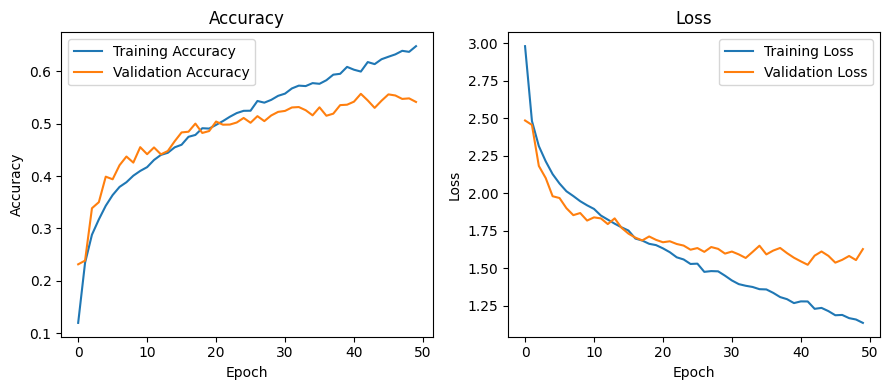

In [ ]:
# Métricas de entrenamiento y validación
train_acc0 = history0.history["accuracy"]
val_acc0 = history0.history['val_accuracy']
train_loss0 = history0.history['loss']
val_loss0 = history0.history['val_loss']

# Configuramos la impresión
fig, axs = plt.subplots(1,2, figsize=(9, 4))

# Imprimimos la comparativa de accuracy de entrenamiento y validación
axs[0].plot(np.arange(len(train_acc0)), train_acc0, label="Training Accuracy")
axs[0].plot(np.arange(len(val_acc0)), val_acc0, label="Validation Accuracy")
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Imprimimos la comparativa de perdida en el entrenamiento y validación
axs[1].plot(np.arange(len(train_loss0)), train_loss0, label="Training Loss")
axs[1].plot(np.arange(len(val_loss0)), val_loss0, label="Validation Loss")
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Mostramos las métricas obtenidas en el conjunto de test

test_loss, test_acc = model0.evaluate(X_t, y_t)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

28/28 [==============================] - 0s 4ms/step - loss: 1.0405 - accuracy: 0.6933
Test loss: 1.04051673412323
Test accuracy: 0.6932584047317505


28/28 [==============================] - 0s 2ms/step


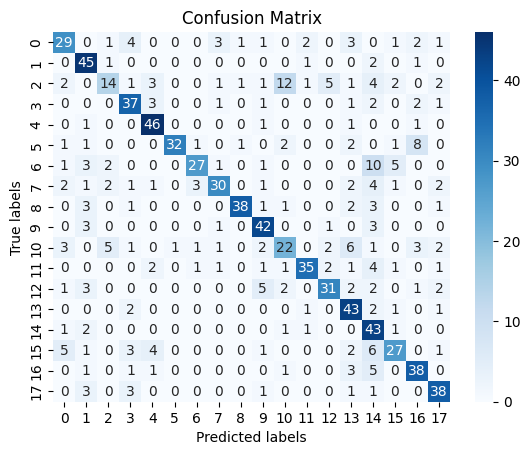

In [ ]:
# Mostramos la matriz de confusión del conjunto de test
y_pred0 = model0.predict(X_t)
y_pred0_labels = np.argmax(y_pred0, axis=1)

# get true labels for test data
y_true0 = np.argmax(y_t, axis=1)

# compute the confusion matrix
confusion0_mtx = confusion_matrix(y_true0, y_pred0_labels)

# plot the confusion matrix as a heatmap
sns.heatmap(confusion0_mtx, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Se puede ver como el modelo se queda entorno al 50% de accuracy en el set de validación y en el set de train alcanza el 60%. Parece que la curva de train seguiría subiendo de aumentar las epochs, mientras que el comportamiento de la de validación parece indicar que ya no aumentaría mucho más: si siguiéramos entrenando probablemente tendríamos overfitting. 

El resultado de test es mejor, casi un 70% de accuracy, aunque sigue sin ser lo suficientemente bueno. Veremos cómo mejora este mismo modelo de fully connected layers al introducir primero una serie de capas convolucionales.

Respecto a la matriz de confusión, la clase que peor se predice es la 2, con solo 14 predicciones buenas de 50 y una gran confusión con la clase 10. La clase que mejor se predice es la 4, con solo 4 fallos de 50 bastante repartidos

### 2.2.1. Crear y entrenar el modelo 1

In [ ]:
# Iniciamos el modelo
model1 = Sequential()

# Añadimos las capas convolucionales
model1.add(Conv2D(32, (3, 3), activation='selu', input_shape=(X.shape[1], X.shape[2], X.shape[3]))) #Especificamos la forma de los datos del tensor de entrada
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3), activation='selu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, (3, 3), activation='selu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Ahora que las capas convolucionales han extraído la información relevante de la imagen, 
# introducimos una capa flatten para convertirlas a vector y poder pasárselas a las fully
# connected layers
model1.add(Flatten())

# Añadimos las capas dense utilizando regularización Dropout
model1.add(Dense(512, activation='selu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='selu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(256, activation='selu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(128, activation='selu'))
model1.add(BatchNormalization())
model1.add(Dense(18, activation='softmax'))

# Compilamos el modelo
model1.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Entrenamos el modelo
history1 = model1.fit(X, y, batch_size=100, epochs=50, validation_data=(X_val, y_val))



Epoch 1/50
152/152 [==============================] - 9s 24ms/step - loss: 2.4615 - accuracy: 0.2876 - val_loss: 2.0008 - val_accuracy: 0.4491
Epoch 2/50
152/152 [==============================] - 5s 30ms/step - loss: 1.8024 - accuracy: 0.4630 - val_loss: 1.6039 - val_accuracy: 0.5354
Epoch 3/50
152/152 [==============================] - 4s 25ms/step - loss: 1.5091 - accuracy: 0.5463 - val_loss: 1.4042 - val_accuracy: 0.5833
Epoch 4/50
152/152 [==============================] - 4s 25ms/step - loss: 1.2927 - accuracy: 0.6095 - val_loss: 1.1506 - val_accuracy: 0.6536
Epoch 5/50
152/152 [==============================] - 4s 29ms/step - loss: 1.1061 - accuracy: 0.6625 - val_loss: 1.1104 - val_accuracy: 0.6728
Epoch 6/50
152/152 [==============================] - 3s 20ms/step - loss: 0.9761 - accuracy: 0.7047 - val_loss: 1.0632 - val_accuracy: 0.6818
Epoch 7/50
152/152 [==============================] - 3s 20ms/step - loss: 0.8392 - accuracy: 0.7394 - val_loss: 0.9570 - val_accuracy: 0.7210

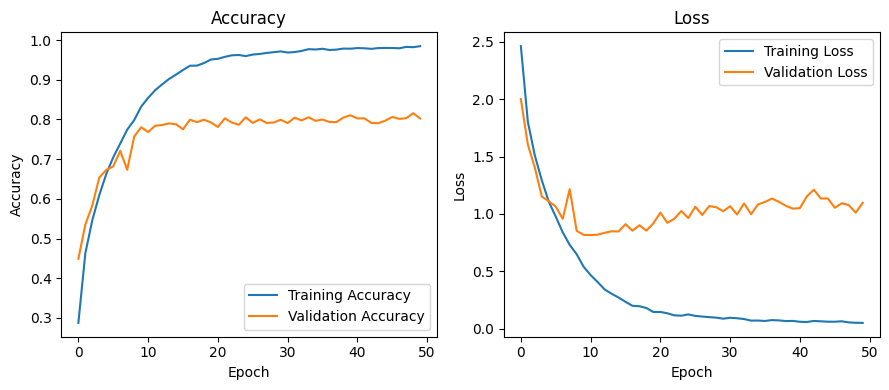

In [ ]:
# Métricas de entrenamiento y validación
train_acc1 = history1.history["accuracy"]
val_acc1 = history1.history['val_accuracy']
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

# Configuramos la impresión
fig, axs = plt.subplots(1,2, figsize=(9, 4))

# Imprimimos la comparativa de accuracy de entrenamiento y validación
axs[0].plot(np.arange(len(train_acc1)), train_acc1, label="Training Accuracy")
axs[0].plot(np.arange(len(val_acc1)), val_acc1, label="Validation Accuracy")
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Imprimimos la comparativa de perdida en el entrenamiento y validación
axs[1].plot(np.arange(len(train_loss1)), train_loss1, label="Training Loss")
axs[1].plot(np.arange(len(val_loss1)), val_loss1, label="Validation Loss")
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Mostramos las métricas finales de entrenamiento y validación:
print('Train loss:', train_loss1[-1])
print('Train accuracy:', train_acc1[-1])

print('Val loss:', val_loss1[-1])
print('Val accuracy:', val_acc1[-1])

Train loss: 0.050028085708618164
Train accuracy: 0.9845981597900391
Val loss: 1.0966438055038452
Val accuracy: 0.802316427230835


In [ ]:
# Mostramos las métricas obtenidas en el conjunto de test

test_loss, test_acc = model1.evaluate(X_t, y_t)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

28/28 [==============================] - 0s 7ms/step - loss: 0.2601 - accuracy: 0.9494
Test loss: 0.2600904703140259
Test accuracy: 0.949438214302063


Los resultados obtenidos con este modelo son mucho mejores que los obtenidos en el punto 2.2.0: la accuracy de test sube unos 15 puntos, el conjunto de train llega casi al 100% y la accuracy de validación sube más de 20 puntos.

A pesar de que los resultados en test sean mucho mejores y podrían aceptarse, en las gráficas mostradas se puede ver como el modelo está sobreentrenado: hay overfitting. Mientras que el conjunto de entrenamiento llega a una accuracy de un 98%, el de validación se queda entorno al 80%, además de que la pérdida deja de bajar y comienza a subir. Para minimizar este fenómeno, probaremos a añadir early stopping monitorizando la pérdida, de manera que se termine el entrenamiento cuando esta comience a subir y se mantengan los pesos de la epoch que dio mejores resultados.

28/28 [==============================] - 0s 4ms/step


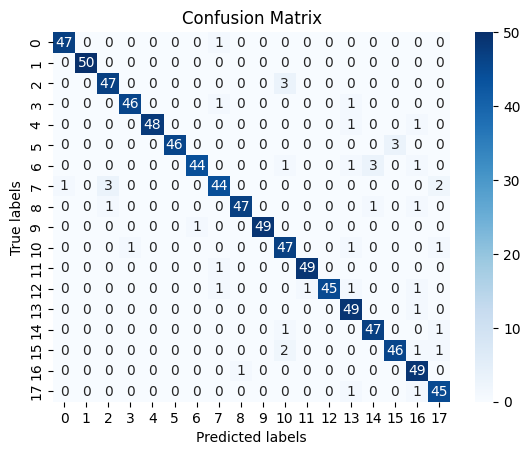

In [ ]:
# Mostramos la matriz de confusión del conjunto de test
y_pred1 = model1.predict(X_t)
y_pred1_labels = np.argmax(y_pred1, axis=1)

# get true labels for test data
y_true1 = np.argmax(y_t, axis=1)

# compute the confusion matrix
confusion1_mtx = confusion_matrix(y_true1, y_pred1_labels)

# plot the confusion matrix as a heatmap
sns.heatmap(confusion1_mtx, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Pese a lo que hemos mencionado acerca del overfitting, como el conjunto de test es un conjunto más "sencillo" y balanceado, la matriz de confusión nos muestra lo que esperábamos con la accuracy obtenida: el modelo que hemos hecho hasta ahora clasifica bien las instancias del conjunto de test.

Respecto a la matriz de confusión, los resultados son mucho mejores ahora, siendo las peores clases la 6 y la 7 con 6 fallos de 50 más o menos repartidos; y la mejor la 1, con un 100% de aciertos. El problema con la clase 7 podría estar ligado al overfitting, dado que es la clase con más representación en el conjunto de entrenamiento.

### 2.1.2. Crear y entrenar el modelo 1 con Early Stopping

In [ ]:
# Early stop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.01, restore_best_weights=True)

# Iniciamos el modelo
model1b = Sequential()

# Añadimos las capas convolucionales
model1b.add(Conv2D(32, (3, 3), activation='selu', input_shape=(X.shape[1], X.shape[2], X.shape[3]))) #Especificamos la forma de los datos del tensor de entrada
model1b.add(MaxPooling2D(pool_size=(2, 2)))
model1b.add(Conv2D(64, (3, 3), activation='selu'))
model1b.add(MaxPooling2D(pool_size=(2, 2)))
model1b.add(Conv2D(128, (3, 3), activation='selu'))
model1b.add(MaxPooling2D(pool_size=(2, 2)))

# Ahora que las capas convolucionales han extraído la información relevante de la imagen, 
# introducimos una capa flatten para convertirlas a vector y poder pasárselas a las fully
# connected layers
model1b.add(Flatten())

# Añadimos las capas dense utilizando regularización Dropout
model1b.add(Dense(512, activation='selu'))
model1b.add(Dropout(0.5))
model1b.add(Dense(256, activation='selu'))
model1b.add(Dropout(0.3))
model1b.add(BatchNormalization())
model1b.add(Dense(256, activation='selu'))
model1b.add(Dropout(0.3))
model1b.add(BatchNormalization())
model1b.add(Dense(128, activation='selu'))
model1b.add(BatchNormalization())
model1b.add(Dense(18, activation='softmax'))

# Compilamos el modelo
model1b.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Entrenamos el modelo
history1b = model1b.fit(X, y, batch_size=100, epochs=50, validation_data=(X_val, y_val), callbacks = [callback])

Epoch 1/50
152/152 [==============================] - 9s 26ms/step - loss: 2.4255 - accuracy: 0.2907 - val_loss: 1.9707 - val_accuracy: 0.4520
Epoch 2/50
152/152 [==============================] - 3s 21ms/step - loss: 1.7862 - accuracy: 0.4664 - val_loss: 1.6350 - val_accuracy: 0.5315
Epoch 3/50
152/152 [==============================] - 4s 24ms/step - loss: 1.4991 - accuracy: 0.5495 - val_loss: 1.5159 - val_accuracy: 0.5628
Epoch 4/50
152/152 [==============================] - 6s 37ms/step - loss: 1.2713 - accuracy: 0.6187 - val_loss: 1.2874 - val_accuracy: 0.6288
Epoch 5/50
152/152 [==============================] - 4s 25ms/step - loss: 1.1112 - accuracy: 0.6625 - val_loss: 1.1191 - val_accuracy: 0.6712
Epoch 6/50
152/152 [==============================] - 4s 27ms/step - loss: 0.9497 - accuracy: 0.7127 - val_loss: 1.1661 - val_accuracy: 0.6496
Epoch 7/50
152/152 [==============================] - 5s 31ms/step - loss: 0.8175 - accuracy: 0.7518 - val_loss: 0.9299 - val_accuracy: 0.7162

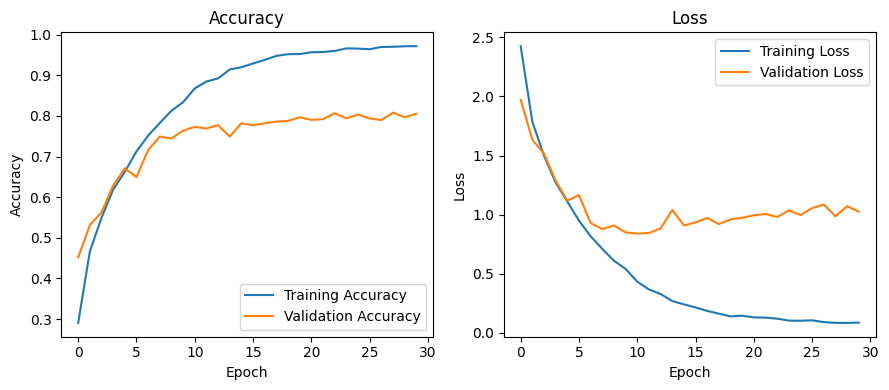

In [ ]:
# Métricas de entrenamiento y validación
train_acc1b = history1b.history["accuracy"]
val_acc1b = history1b.history['val_accuracy']
train_loss1b = history1b.history['loss']
val_loss1b = history1b.history['val_loss']

# Configuramos la impresión
fig, axs = plt.subplots(1,2, figsize=(9, 4))

# Imprimimos la comparativa de accuracy de entrenamiento y validación
axs[0].plot(np.arange(len(train_acc1b)), train_acc1b, label="Training Accuracy")
axs[0].plot(np.arange(len(val_acc1b)), val_acc1b, label="Validation Accuracy")
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Imprimimos la comparativa de perdida en el entrenamiento y validación
axs[1].plot(np.arange(len(train_loss1b)), train_loss1b, label="Training Loss")
axs[1].plot(np.arange(len(val_loss1b)), val_loss1b, label="Validation Loss")
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Mostramos las métricas obtenidas en el conjunto de test

test_loss, test_acc = model1b.evaluate(X_t, y_t)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

28/28 [==============================] - 0s 5ms/step - loss: 0.2474 - accuracy: 0.9494
Test loss: 0.24743901193141937
Test accuracy: 0.949438214302063


28/28 [==============================] - 0s 3ms/step


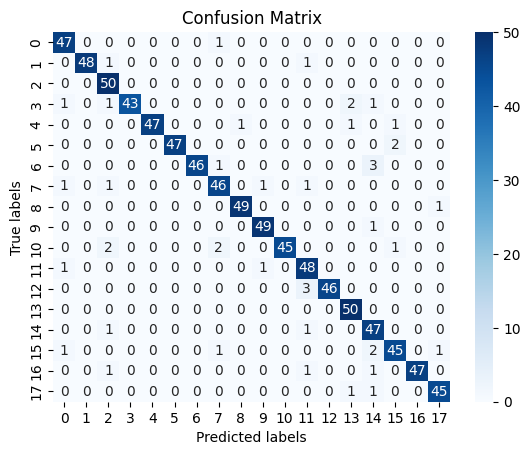

In [ ]:
# MATRIZ DE CONFUSIÓN
y_pred1b = model1b.predict(X_t)
y_pred1b_labels = np.argmax(y_pred1b, axis=1)

# get true labels for test data
y_true1b = np.argmax(y_t, axis=1)

# compute the confusion matrix
confusion1b_mtx = confusion_matrix(y_true1b, y_pred1b_labels)

# plot the confusion matrix as a heatmap
sns.heatmap(confusion1b_mtx, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

En este caso la matriz de confusión muestra 2 clases con un 100% de aciertos, la 2 y la 13; y clasifica peor las clases 3, 10 y 15, con 5 fallos de 50.

### 2.1.3. Comparar los resultados con y sin Early Stop

Como ya obteníamos muy buenos resultados sin Early Stop, los resultados obtenidos al utilizarlo son muy similares. Utilizaremos los classification reports para comparar ambos modelos:

In [ ]:
print("Classification report del modelo sin Early stop")
print(classification_report(y_true1, y_pred1_labels))

Classification report del modelo sin Early stop
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       1.00      1.00      1.00        50
           2       0.92      0.94      0.93        50
           3       0.98      0.96      0.97        48
           4       1.00      0.96      0.98        50
           5       1.00      0.94      0.97        49
           6       0.98      0.88      0.93        50
           7       0.92      0.88      0.90        50
           8       0.98      0.94      0.96        50
           9       1.00      0.98      0.99        50
          10       0.87      0.94      0.90        50
          11       0.98      0.98      0.98        50
          12       1.00      0.92      0.96        49
          13       0.89      0.98      0.93        50
          14       0.92      0.96      0.94        49
          15       0.94      0.92      0.93        50
          16       0.88      0.98

In [ ]:
print("Classification report del modelo con Early stop")
print(classification_report(y_true1b, y_pred1b_labels))

Classification report del modelo con Early stop
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        48
           1       1.00      0.96      0.98        50
           2       0.88      1.00      0.93        50
           3       1.00      0.90      0.95        48
           4       1.00      0.94      0.97        50
           5       1.00      0.96      0.98        49
           6       1.00      0.92      0.96        50
           7       0.90      0.92      0.91        50
           8       0.98      0.98      0.98        50
           9       0.96      0.98      0.97        50
          10       1.00      0.90      0.95        50
          11       0.87      0.96      0.91        50
          12       1.00      0.94      0.97        49
          13       0.93      1.00      0.96        50
          14       0.84      0.96      0.90        49
          15       0.92      0.90      0.91        50
          16       1.00      0.94

 Como decíamos, son resultados muy similares. De hecho, son ligeramente peores en algunas clases con el Early Stop, pero no es una diferencia significativa y, por otro lado, hemos reducido el tiempo y complejidad de cómputo al necesitar únicamente 30 epochs para obtener el mismo resultado. 

### 2.1.4. Data Augmentation

A pesar de que ya disponemos de un modelo aceptable, es cierto que funciona peor en el conjunto de validación. Esto se debe, probablemente, al desbalanceo de clases; por lo que intentaremos mejorar el modelo mediante el aumento de los datos de entrenamiento, buscando reducir el desbalanceo. Para ello, utilizaremos ImageDataGenerator

In [ ]:
# Creamos un objeto ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Rota las imágenes aleatoriamente hasta 20º
    width_shift_range=0.1,  # Gira las imágenes horizontalmente de manera aleatoria hasta un 10%
    height_shift_range=0.1,  # Gira las imágenes verticalmente de manera aleatoria hasta un 10%
    zoom_range=0.1,  # Acerca las imágenes aleatoriamente hasta un 10%
    horizontal_flip=True  # Invierte las imágenes horizontalmente de manera aleatoria
)

# Lo ajustamos a nuestro conjunto de entrenamiento
train_datagen.fit(X)

# Early stop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.01, restore_best_weights=True)

# Iniciamos el modelo
model2 = Sequential()

# Añadimos las capas convolucionales
model2.add(Conv2D(32, (3, 3), activation='selu', input_shape=(X.shape[1], X.shape[2], X.shape[3]))) #Especificamos la forma de los datos del tensor de entrada
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='selu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, (3, 3), activation='selu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Ahora que las capas convolucionales han extraído la información relevante de la imagen, 
# introducimos una capa flatten para convertirlas a vector y poder pasárselas a las fully
# connected layers
model2.add(Flatten())

# Añadimos las capas dense utilizando regularización Dropout
model2.add(Dense(512, activation='selu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='selu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='selu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='selu'))
model2.add(BatchNormalization())
model2.add(Dense(18, activation='softmax'))

# Compilamos el modelo
model2.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Entrenamos el modelo con los datos aumentados
history2 = model2.fit(
    train_datagen.flow(X, y, batch_size=32),
    steps_per_epoch=len(X) // 32,  # number of batches per epoch
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks = [callback]
)


Epoch 1/50
474/474 [==============================] - 27s 45ms/step - loss: 2.5664 - accuracy: 0.2359 - val_loss: 1.9885 - val_accuracy: 0.3964
Epoch 2/50
474/474 [==============================] - 23s 48ms/step - loss: 1.9541 - accuracy: 0.4037 - val_loss: 1.5103 - val_accuracy: 0.5417
Epoch 3/50
474/474 [==============================] - 29s 61ms/step - loss: 1.7024 - accuracy: 0.4798 - val_loss: 1.3277 - val_accuracy: 0.5854
Epoch 4/50
474/474 [==============================] - 25s 52ms/step - loss: 1.5251 - accuracy: 0.5317 - val_loss: 1.2360 - val_accuracy: 0.6223
Epoch 5/50
474/474 [==============================] - 21s 45ms/step - loss: 1.3817 - accuracy: 0.5835 - val_loss: 1.0672 - val_accuracy: 0.6636
Epoch 6/50
474/474 [==============================] - 29s 62ms/step - loss: 1.2676 - accuracy: 0.6110 - val_loss: 0.9364 - val_accuracy: 0.7031
Epoch 7/50
474/474 [==============================] - 21s 44ms/step - loss: 1.1926 - accuracy: 0.6347 - val_loss: 0.9157 - val_accuracy:

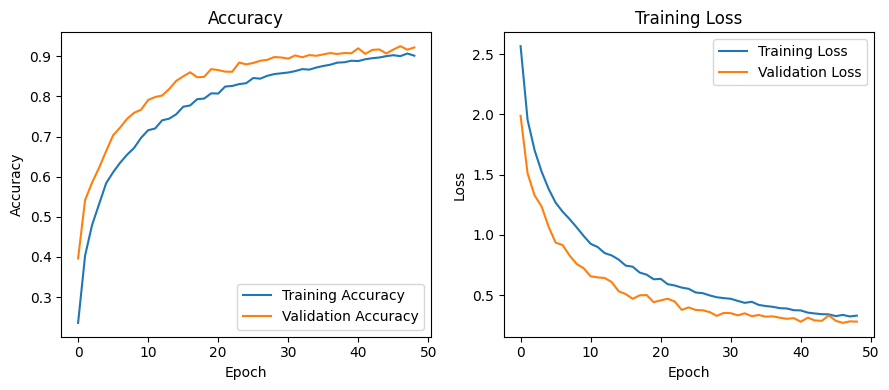

In [ ]:
# Métricas de entrenamiento y validación
train_acc2 = history2.history["accuracy"]
val_acc2 = history2.history['val_accuracy']
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Configuramos la impresión
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Imprimimos la comparativa de accuracy de entrenamiento
axs[0].plot(np.arange(len(train_acc2)), train_acc2, label="Training Accuracy")
axs[0].plot(np.arange(len(val_acc2)), val_acc2, label="Validation Accuracy")
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Imprimimos la comparativa de perdida en el entrenamiento
axs[1].plot(np.arange(len(train_loss2)), train_loss2, label="Training Loss")
axs[1].plot(np.arange(len(val_loss2)), val_loss2, label="Validation Loss")
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Mostramos la figura
plt.tight_layout()
plt.show()

In [ ]:
# Mostramos las métricas obtenidas en el conjunto de test
test_loss, test_acc = model2.evaluate(X_t, y_t)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

28/28 [==============================] - 0s 5ms/step - loss: 0.1499 - accuracy: 0.9573
Test loss: 0.1499018669128418
Test accuracy: 0.9573033452033997


28/28 [==============================] - 0s 3ms/step


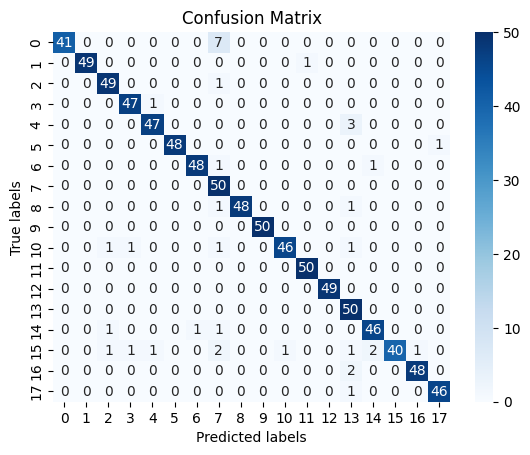

In [ ]:
# MATRIZ DE CONFUSIÓN
y_pred2 = model2.predict(X_t)
y_pred2_labels = np.argmax(y_pred2, axis=1)

# get true labels for test data
y_true2 = np.argmax(y_t, axis=1)

# compute the confusion matrix
confusion2_mtx = confusion_matrix(y_true2, y_pred2_labels)

# plot the confusion matrix as a heatmap
sns.heatmap(confusion2_mtx, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Nuestro modelo final tiene varias clases con un 100% de aciertos: la 7, la 9, la 11, la 12 y la 13; pero también falla más en la clase 0 (que la confunde en todos sus fallos con la 7) y en la 15 (con fallos más distribuidos entre clases)

### 2.1.5. Comparativa final

Los resultados nos muestran como, sin necesidad de aumentar los datos de validación, únicamente los de entrenamiento, hemos mejorado considerablemente las métricas de validación, que no llegaban apenas al 80% de accuracy frente al 90% que obtenemos ahora. Además, las curvas de train y validación siguen un comportamiento similar, lo cual indica que ya hemos solventado el problema de overfitting que parecíamos tener anteriormente. Por último, los resultados de test también han aumentado respecto de los modelos anteriores, llegando a  superar el 95%. 

Para finalizar, compararemos los clasification reports del modelo 1 con early stopping (modelo 1b) y del modelo 2, el actual, con data augmentation:

In [ ]:
print("Classification report del modelo 1 con Early stop")
print(classification_report(y_true1b, y_pred1b_labels))

Classification report del modelo 1 con Early stop
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        48
           1       1.00      0.96      0.98        50
           2       0.88      1.00      0.93        50
           3       1.00      0.90      0.95        48
           4       1.00      0.94      0.97        50
           5       1.00      0.96      0.98        49
           6       1.00      0.92      0.96        50
           7       0.90      0.92      0.91        50
           8       0.98      0.98      0.98        50
           9       0.96      0.98      0.97        50
          10       1.00      0.90      0.95        50
          11       0.87      0.96      0.91        50
          12       1.00      0.94      0.97        49
          13       0.93      1.00      0.96        50
          14       0.84      0.96      0.90        49
          15       0.92      0.90      0.91        50
          16       1.00      0.

In [ ]:
print("Classification report del modelo 2 con data augmentation")
print(classification_report(y_true2, y_pred2_labels))

Classification report del modelo 2 con data augmentation
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        48
           1       1.00      0.98      0.99        50
           2       0.94      0.98      0.96        50
           3       0.96      0.98      0.97        48
           4       0.96      0.94      0.95        50
           5       1.00      0.98      0.99        49
           6       0.98      0.96      0.97        50
           7       0.78      1.00      0.88        50
           8       1.00      0.96      0.98        50
           9       1.00      1.00      1.00        50
          10       0.98      0.92      0.95        50
          11       0.98      1.00      0.99        50
          12       1.00      1.00      1.00        49
          13       0.85      1.00      0.92        50
          14       0.94      0.94      0.94        49
          15       1.00      0.80      0.89        50
          16       0.98 

Además de aumentar ligeramente la accuracy general en test, el f1-score mejora para casi todas las clases (con alguna excepción), quedando la siguiente comparativa media:


*   Precisión media: 0,953 (M1) vs 0,963 (M2)
*   Recall medio: 0,95 (M1) vs 0,957 (M2)
*   f1-score medio: 0,951 (M1) vs 0,96 (M2)

Teniendo en cuenta que los resultados obtenidos previamente ya eran muy buenos, es relevante mencionar que (aunque sea ligeramente) se han conseguido aumentar todas las métricas mediante el aumento de datos, tanto en test como en validación.


# 3. Conclusiones

A lo largo de este notebook se han podido comprobar una serie de cosas:

En primer lugar, se ha comprobado como las redes neuronales convolucionales funcionan mucho mejor que las fully connected en el caso de imágenes. Simplemente añadiendo las capas convolucionales conseguimos mejorar en 15, 20 y casi 40 puntos los conjuntos de test, validación y train, respectivamente. 

En segundo lugar, hemos visto como al hacer redes profundas, de varias capas más o menos grandes, hemos provocado overfitting. Esto se ha solventado mediante el uso de early stop que, si bien no ha permitido mejores resultados, al menos ha reducido las epochs de 50 a 30, reduciendo el tiempo y complejidad de cómputo mientras que mantenía los resultados

Por último, hemos comprobado como el desbalanceo de clases del conjunto de entrenamiento tiene consecuencias negativas en el modelo. Para solventar este problema, aumentamos los datos de entrenamiento mediante la clase ImageDataGenerator de Keras. Hemos hecho este aumento únicamente con los datos de entrenamiento y no también en los de validación porque conlleva un aumento considerable del tiempo de cómputo: pasa a tardar cada epoch entre 20 y 30 segundos frente a los 10 s máximo que tardaba el modelo 1b (con Early Stop). Sin embargo, sin necesidad de aumentar también los datos de validación, hemos conseguido mejorar, de media, todas las métricas de los modelos anteriores. 

De esta manera, hemos conseguido un modelo final con un **85% de accuracy en train, un 90% de accuracy en validación y un 96% de accuracy en test**, sin overfitting y con unas f1-score por clase por encima del 88% en todos los casos. Por tanto, podemos decir que hemos logrado un buen modelo capaz de predecir satisfactoriamente los 18 personajes de los Simpsons elegidos.